In [1]:
import pandas as pd

# Inegi

In [2]:
inegi = pd.read_csv('inegi.csv')
inegi.drop(columns=['nom_estab', 'per_ocu', 'fecha_alta', 'nom_processed', 'tipoUniEco'], inplace=True)
inegi.columns

Index(['entidad', 'municipio', 'localidad', 'latitud', 'longitud', 'tipo',
       'Cocina Económica', 'Antojitos', 'Pizza', 'Hamburguesas', 'Hot Dogs',
       'Sushi', 'Tamales', 'Mariscos', 'Pescado', 'Tacos', 'Carne', 'Asada',
       'Panuchos', 'Cochinita', 'Pollo', 'Desayunos', 'Tortas', 'Mondongo',
       'Menudo', 'Memelas', 'Empanadas', 'Chicharrón', 'Gorditas', 'Costillas',
       'Carnitas', 'Doraditas', 'Baguettes', 'Parrilla', 'Huaraches',
       'Rosticería', 'China', 'Yucateca', 'Tabasqueña', 'Arrachera', 'Pastor',
       'Birria', 'Barbacoa', 'Carnero', 'Pozole', 'Enchiladas', 'Chilaquiles'],
      dtype='object')

In [3]:
inegi['entidad'] = inegi['entidad'].apply(lambda x: 'YUCATAN' if 'YUCA' in x else x)
yinegi = inegi[inegi['entidad']=='YUCATAN']
yinegi.head()

,entidad,municipio,localidad,latitud,longitud,tipo,Cocina Económica,Antojitos,Pizza,Hamburguesas,...,Yucateca,Tabasqueña,Arrachera,Pastor,Birria,Barbacoa,Carnero,Pozole,Enchiladas,Chilaquiles
152158,YUCATAN,Mérida,Mérida,21.001433,-89.605708,['arracher'],0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
152159,YUCATAN,Mérida,Mérida,21.038795,-89.601918,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152160,YUCATAN,Mérida,Mérida,21.024276,-89.624382,[],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152161,YUCATAN,Mérida,Mérida,21.020646,-89.585322,['restaur'],0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152162,YUCATAN,Mérida,Mérida,20.998787,-89.566374,['pizz'],0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
yinegi['localidad'].value_counts()

Mérida                      7475
Valladolid                   636
Kanasín                      600
Tizimín                      529
Ticul                        483
                            ... 
Noc Ac                         1
Xcanatún                       1
San Francisco Manzanilla       1
El Cuyo                        1
Santa Clara                    1
Name: localidad, Length: 157, dtype: int64

In [5]:
yinegi.drop(yinegi[yinegi['localidad']!='Mérida'].index, inplace=True)
yinegi['localidad'].value_counts()

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mérida    7475
Name: localidad, dtype: int64

In [6]:
foods = ['Cocina Económica', 'Antojitos', 'Pizza', 'Hamburguesas', 'Hot Dogs', 'Sushi', 'Tamales', 'Mariscos', 
         'Pescado', 'Tacos', 'Carne', 'Asada', 'Panuchos', 'Cochinita', 'Pollo', 'Desayunos', 'Tortas', 'Mondongo', 
         'Menudo', 'Memelas', 'Empanadas', 'Chicharrón', 'Gorditas', 'Costillas', 'Carnitas', 'Doraditas', 
         'Baguettes', 'Parrilla', 'Huaraches', 'Rosticería', 'China', 'Yucateca', 'Tabasqueña', 'Arrachera', 
         'Pastor', 'Birria', 'Barbacoa', 'Carnero', 'Pozole', 'Enchiladas', 'Chilaquiles']

In [7]:
inegi_results = {}

for food in foods:
    inegi_results[food] = yinegi[food].sum()
    
inegi_results

{'Cocina Económica': 1409,
 'Antojitos': 1030,
 'Pizza': 309,
 'Hamburguesas': 149,
 'Hot Dogs': 36,
 'Sushi': 42,
 'Tamales': 91,
 'Mariscos': 59,
 'Pescado': 91,
 'Tacos': 670,
 'Carne': 1,
 'Asada': 177,
 'Panuchos': 198,
 'Cochinita': 118,
 'Pollo': 230,
 'Desayunos': 89,
 'Tortas': 203,
 'Mondongo': 13,
 'Menudo': 0,
 'Memelas': 0,
 'Empanadas': 27,
 'Chicharrón': 74,
 'Gorditas': 10,
 'Costillas': 15,
 'Carnitas': 40,
 'Doraditas': 23,
 'Baguettes': 6,
 'Parrilla': 43,
 'Huaraches': 7,
 'Rosticería': 20,
 'China': 0,
 'Yucateca': 48,
 'Tabasqueña': 13,
 'Arrachera': 4,
 'Pastor': 22,
 'Birria': 0,
 'Barbacoa': 15,
 'Carnero': 1,
 'Pozole': 12,
 'Enchiladas': 1,
 'Chilaquiles': 0}

In [8]:
pd.set_option('display.max_rows', 20)

In [9]:
df = pd.DataFrame(inegi_results.items(), columns = ['Index', 'InegiCount']).set_index('Index')
df.head()

,InegiCount
Index,
Cocina Económica,1409
Antojitos,1030
Pizza,309
Hamburguesas,149
Hot Dogs,36


# Google Trends

### Revisaremos qué tantas búsquedas se hacen en Google sobre cada uno de los giros de comida, con el fin de conocer dónde está el interés del consumidor.
### Para esto utilizaremos la API de Google Trends a través de pytrends.

In [10]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='es-MX', tz=360)

In [11]:
resultados = []
for comida in inegi_results:
    print(comida)
    pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
    resultados.append(pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False))
    
resultados

Cocina Económica
Antojitos
Pizza
Hamburguesas
Hot Dogs
Sushi
Tamales
Mariscos
Pescado
Tacos
Carne
Asada
Panuchos
Cochinita
Pollo
Desayunos
Tortas
Mondongo
Menudo
Memelas
Empanadas
Chicharrón
Gorditas
Costillas
Carnitas
Doraditas
Baguettes
Parrilla
Huaraches
Rosticería
China
Yucateca
Tabasqueña
Arrachera
Pastor
Birria
Barbacoa
Carnero
Pozole
Enchiladas
Chilaquiles


[                     Cocina Económica
 geoName                              
 Aguascalientes                      0
 Baja California                     0
 Baja California Sur                 0
 Campeche                            0
 Chiapas                             0
 ...                               ...
 Tamaulipas                          0
 Tlaxcala                            0
 Veracruz                            0
 Yucatán                           100
 Zacatecas                           0
 
 [32 rows x 1 columns],                      Antojitos
 geoName                       
 Aguascalientes              12
 Baja California             23
 Baja California Sur         24
 Campeche                   100
 Chiapas                     34
 ...                        ...
 Tamaulipas                  26
 Tlaxcala                    20
 Veracruz                    59
 Yucatán                     36
 Zacatecas                   42
 
 [32 rows x 1 columns],                      Pizza

### Como los resultados nos los da por estados, filtramos y nos quedamos con las búsquedas en Yucatán.

In [12]:
busquedas = resultados[0].join(resultados[1:]).T
busquedas

geoName,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatán,Zacatecas
Cocina Económica,0,0,0,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,0,100,0
Antojitos,12,23,24,100,34,31,19,15,28,33,...,48,37,24,20,46,26,20,59,36,42
Pizza,71,83,75,82,79,66,85,71,79,67,...,98,82,74,76,77,62,39,65,100,45
Hamburguesas,65,66,41,45,40,74,67,69,100,54,...,47,53,77,71,48,56,37,55,47,67
Hot Dogs,40,92,78,0,20,47,46,42,57,47,...,40,29,100,96,28,37,0,37,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Barbacoa,33,35,33,51,54,55,37,32,100,35,...,46,39,47,56,82,34,33,58,31,26
Carnero,25,10,0,16,16,9,62,15,0,15,...,39,16,7,11,5,17,73,19,100,0
Pozole,27,24,25,23,17,18,25,21,100,18,...,25,41,20,20,24,22,21,23,25,24
Enchiladas,87,53,71,37,37,66,59,77,95,87,...,62,98,79,54,60,62,43,55,44,100


In [13]:
trends = busquedas['Yucatán'].sort_values(ascending=False)
trends

Cocina Económica    100
Parrilla            100
Pizza               100
Carnero             100
Panuchos            100
                   ... 
Gorditas             17
Birria               15
Tabasqueña           11
Menudo               11
Rosticería            0
Name: Yucatán, Length: 41, dtype: int64

In [14]:
df['GoogleTrend'] = trends
df

,InegiCount,GoogleTrend
Index,,
Cocina Económica,1409,100
Antojitos,1030,36
Pizza,309,100
Hamburguesas,149,47
Hot Dogs,36,32
...,...,...
Barbacoa,15,31
Carnero,1,100
Pozole,12,25


## Interest over time

In [15]:
iot = {}
for comida in inegi_results:
    print(comida)
    pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
    iot[comida] = pytrends.interest_over_time()
    
iot

Cocina Económica
Antojitos
Pizza
Hamburguesas
Hot Dogs
Sushi
Tamales
Mariscos
Pescado
Tacos
Carne
Asada
Panuchos
Cochinita
Pollo
Desayunos
Tortas
Mondongo
Menudo
Memelas
Empanadas
Chicharrón
Gorditas
Costillas
Carnitas
Doraditas
Baguettes
Parrilla
Huaraches
Rosticería
China
Yucateca
Tabasqueña
Arrachera
Pastor
Birria
Barbacoa
Carnero
Pozole
Enchiladas
Chilaquiles


{'Cocina Económica':             Cocina Económica  isPartial
 date                                   
 2015-03-08                 0      False
 2015-03-15                 0      False
 2015-03-22                53      False
 2015-03-29                 0      False
 2015-04-05                 0      False
 ...                      ...        ...
 2020-01-26                71      False
 2020-02-02                36      False
 2020-02-09                35      False
 2020-02-16                34      False
 2020-02-23                45      False
 
 [260 rows x 2 columns], 'Antojitos':             Antojitos  isPartial
 date                            
 2015-03-08         17      False
 2015-03-15         14      False
 2015-03-22         23      False
 2015-03-29         16      False
 2015-04-05         21      False
 ...               ...        ...
 2020-01-26         34      False
 2020-02-02         36      False
 2020-02-09         35      False
 2020-02-16         40      False


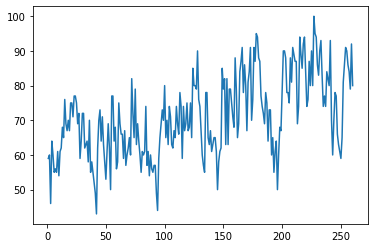

In [45]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(len(iot['Desayunos']['Desayunos']))]

#for food in foods:
plt.plot(x, iot['Desayunos']['Desayunos'].values);

In [ ]:
iot['Gorditas']

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

slope = {}
for food in foods:
    linreg.fit(np.array(x).reshape(-1,1), iot[food][food].values)
    slope[food] = linreg.intercept_

slope

{'Cocina Económica': 12.66234036234036,
 'Antojitos': 19.336976536976536,
 'Pizza': 40.087050787050785,
 'Hamburguesas': 10.41152361152361,
 'Hot Dogs': 42.7003861003861,
 'Sushi': 44.04942084942085,
 'Tamales': 13.209385209385209,
 'Mariscos': 21.129106029106026,
 'Pescado': 30.364627264627263,
 'Tacos': 38.642500742500744,
 'Carne': 40.8100386100386,
 'Asada': 11.742827442827442,
 'Panuchos': 32.227769527769524,
 'Cochinita': 43.096792396792395,
 'Pollo': 56.40700920700921,
 'Desayunos': 59.64986634986634,
 'Tortas': 56.799198099198094,
 'Mondongo': 15.299732699732695,
 'Menudo': 15.078318978318975,
 'Memelas': 26.673834273834274,
 'Empanadas': 19.907573507573506,
 'Chicharrón': 3.4191565191565196,
 'Gorditas': 46.07915057915058,
 'Costillas': 16.062132462132464,
 'Carnitas': 31.02863082863082,
 'Doraditas': 22.064300564300563,
 'Baguettes': 34.95530145530146,
 'Parrilla': 32.88316008316009,
 'Huaraches': 27.542174042174032,
 'Rosticería': 5.054232254232255,
 'China': 20.273091773091

In [69]:
for key in slope:
    df['slope'].loc[key] = slope[key]
df.slope = df.slope.astype('float64')
df.dtypes

InegiCount       int64
GoogleTrend      int64
slope          float64
YelpRating     float64
score           object
dtype: object

### Con esto, tenemos parametrizado el interés en el estado por cada uno de los giros de comida.
### Ahora, necesitamos revisar el grado de satisfacción de los usuarios por la oferta existente.

# Yelp

### Utilizando la API de Yelp, hacemos búsquedas nuevamente sobre los diferentes giros de comida para encontrar negocios y sus calificaciónes en la plataforma.

In [25]:
import requests
from bs4 import BeautifulSoup as bs
import json

In [26]:
client_id = 'JPrLnyol5AaT0XLf7CYbWg'
api_key = '5F0kTJmEIUsrAXKEcpqHA_HvL2uKWA3HZC_iQ73dGgIXgke7fCh84CBP5KpwVMXumfm4BahGo3iaBiNtBi9Q9vexfphH6urta05XSFaaQCs6aphzSQfWwhWSo_6nXHYx'
app_name = 'ravenous'

endpoint = 'https://api.yelp.com/v3/businesses/search?'
req_parameters_1 = ['location']
req_parameters_2 = ['latitud', 'longitude']
optional_parameters = ['term', 'radius', 'categories', 'locale', 'limit', 'sort_by', 'price']

In [30]:
yelp_search = []
for comida in foods:
    term = 'term={}&'.format(comida)
    print(term)
    location = 'latitude=21.073881&longitude=-89.655476&'
    locale = 'locale=es_MX&'
    radius = 'radius=3000&'
    limit = 'limit=50' 
    res = requests.get(endpoint+term+location+locale+radius+limit, headers={'Authorization':'Bearer '+api_key})
    soup = bs(res.content)
    yelp_json = json.loads(soup.findAll('p')[0].text)
    ydf = pd.DataFrame(yelp_json['businesses'])
    ydf['tipo'] = comida
    yelp_search.append(ydf)
    
yelp_search

term=Cocina Económica&
term=Antojitos&
term=Pizza&
term=Hamburguesas&
term=Hot Dogs&
term=Sushi&
term=Tamales&
term=Mariscos&
term=Pescado&
term=Tacos&
term=Carne&
term=Asada&
term=Panuchos&
term=Cochinita&
term=Pollo&
term=Desayunos&
term=Tortas&
term=Mondongo&
term=Menudo&
term=Memelas&
term=Empanadas&
term=Chicharrón&
term=Gorditas&
term=Costillas&
term=Carnitas&
term=Doraditas&
term=Baguettes&
term=Parrilla&
term=Huaraches&
term=Rosticería&
term=China&
term=Yucateca&
term=Tabasqueña&
term=Arrachera&
term=Pastor&
term=Birria&
term=Barbacoa&
term=Carnero&
term=Pozole&
term=Enchiladas&
term=Chilaquiles&


[Empty DataFrame
 Columns: [tipo]
 Index: [], Empty DataFrame
 Columns: [tipo]
 Index: [],                        id                                          alias  \
 0  39j8D_eznJbJ6_ERzhIWng                              bella-roma-mérida   
 1  DQVZmAV67SIPXOWcfbBfuQ  cafetería-facultad-de-matemáticas-uady-mérida   
 
                                      name  \
 0                              Bella Roma   
 1  Cafetería Facultad De Matemáticas UADY   
 
                                            image_url  is_closed  \
 0  https://s3-media2.fl.yelpcdn.com/bphoto/n5QXPh...      False   
 1  https://s3-media4.fl.yelpcdn.com/bphoto/Y_wxih...      False   
 
                                                  url  review_count  \
 0  https://www.yelp.com.mx/biz/bella-roma-m%C3%A9...             9   
 1  https://www.yelp.com.mx/biz/cafeter%C3%ADa-fac...             3   
 
                                           categories  rating  \
 0  [{'alias': 'italian', 'title': 'Cocina italian.

In [31]:
lugares = pd.concat(yelp_search, axis=0, sort=False)
print(lugares.shape)
lugares.reset_index(inplace=True)
lugares

(22, 17)


,index,tipo,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,0,Pizza,39j8D_eznJbJ6_ERzhIWng,bella-roma-mérida,Bella Roma,https://s3-media2.fl.yelpcdn.com/bphoto/n5QXPh...,False,https://www.yelp.com.mx/biz/bella-roma-m%C3%A9...,9.0,"[{'alias': 'italian', 'title': 'Cocina italian...",4.5,"{'latitude': 21.0716194744981, 'longitude': -8...",[],$$,"{'address1': 'Calle 57-B S/N', 'address2': '',...",+529992273837,01 999 227 3837,917.867454
1,1,Pizza,DQVZmAV67SIPXOWcfbBfuQ,cafetería-facultad-de-matemáticas-uady-mérida,Cafetería Facultad De Matemáticas UADY,https://s3-media4.fl.yelpcdn.com/bphoto/Y_wxih...,False,https://www.yelp.com.mx/biz/cafeter%C3%ADa-fac...,3.0,"[{'alias': 'delis', 'title': 'Tortas'}]",4.5,"{'latitude': 21.048168255592, 'longitude': -89...",[],NaN,"{'address1': 'Anillo Periferico Norte', 'addre...",,,3074.036996
2,0,Hamburguesas,vKSmXOhH2JcIcCCu5SoZzA,angry-angus-hamburguesas-mérida-2,Angry Angus Hamburguesas,https://s3-media2.fl.yelpcdn.com/bphoto/4SXq9M...,False,https://www.yelp.com.mx/biz/angry-angus-hambur...,22.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",4.0,"{'latitude': 21.0691342629407, 'longitude': -8...",[],$,"{'address1': 'Calle 59 718', 'address2': 'Col....",+529993165776,01 999 316 5776,877.738489
3,1,Hamburguesas,ih71mOReXxJ1ITWq0mg46g,burger-navy-mérida,Burger Navy,https://s3-media2.fl.yelpcdn.com/bphoto/EpTLH_...,False,https://www.yelp.com.mx/biz/burger-navy-m%C3%A...,3.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",3.5,"{'latitude': 21.0304604, 'longitude': -89.6354...",[],NaN,"{'address1': 'Av. 1 A Fovissste', 'address2': ...",,,2663.760936
4,0,Hot Dogs,vKSmXOhH2JcIcCCu5SoZzA,angry-angus-hamburguesas-mérida-2,Angry Angus Hamburguesas,https://s3-media2.fl.yelpcdn.com/bphoto/4SXq9M...,False,https://www.yelp.com.mx/biz/angry-angus-hambur...,22.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",4.0,"{'latitude': 21.0691342629407, 'longitude': -8...",[],$,"{'address1': 'Calle 59 718', 'address2': 'Col....",+529993165776,01 999 316 5776,877.738489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,0,Doraditas,DQVZmAV67SIPXOWcfbBfuQ,cafetería-facultad-de-matemáticas-uady-mérida,Cafetería Facultad De Matemáticas UADY,https://s3-media4.fl.yelpcdn.com/bphoto/Y_wxih...,False,https://www.yelp.com.mx/biz/cafeter%C3%ADa-fac...,3.0,"[{'alias': 'delis', 'title': 'Tortas'}]",4.5,"{'latitude': 21.048168255592, 'longitude': -89...",[],NaN,"{'address1': 'Anillo Periferico Norte', 'addre...",,,3074.036996
18,0,Parrilla,Vn-iU80DUPjhX2fxYg2Kzg,finca-grill-mérida,Finca Grill,https://s3-media2.fl.yelpcdn.com/bphoto/2BvNoW...,False,https://www.yelp.com.mx/biz/finca-grill-m%C3%A...,1.0,"[{'alias': 'steak', 'title': 'Parrilla'}]",5.0,"{'latitude': 21.0696489457516, 'longitude': -8...",[],NaN,"{'address1': 'Calle 100', 'address2': '', 'add...",,,476.965563
19,0,Arrachera,vKSmXOhH2JcIcCCu5SoZzA,angry-angus-hamburguesas-mérida-2,Angry Angus Hamburguesas,https://s3-media2.fl.yelpcdn.com/bphoto/4SXq9M...,False,https://www.yelp.com.mx/biz/angry-angus-hambur...,22.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",4.0,"{'latitude': 21.0691342629407, 'longitude': -8...",[],$,"{'address1': 'Calle 59 718', 'address2': 'Col....",+529993165776,01 999 316 5776,877.738489
20,1,Arrachera,kVNGwAwtPlupStrd0nAp4w,salamanca-bar-y-grill-mérida,Salamanca Bar & Grill,https://s3-media2.fl.yelpcdn.com/bphoto/IR6OYG...,False,https://www.yelp.com.mx/biz/salamanca-bar-y-gr...,4.0,"[{'alias': 'argentine', 'title': 'Cocina argen...",5.0,"{'latitude': 21.0576879626933, 'longitude': -8...",[],$$,"{'address1': '', 'address2': '', 'address3': '...",,,2183.682732


In [32]:
lugares.tipo.value_counts()

Carne           4
Arrachera       2
Hamburguesas    2
Hot Dogs        2
Pizza           2
Tortas          2
Tacos           1
Empanadas       1
Pastor          1
Desayunos       1
Doraditas       1
Asada           1
Parrilla        1
Sushi           1
Name: tipo, dtype: int64

In [33]:
#lugares.reset_index(inplace=True)

### La información más relevante que extraemos de Yelp es el 'rating' por giro de comida, por lo que de los resultados sacamos promedios basados en su giro.

In [34]:
ratings = dict(lugares.tipo.value_counts())
for comida in inegi_results:
    ratings[comida] = lugares[lugares.tipo == comida]['rating'].mean()
ratings

{'Carne': 4.625,
 'Arrachera': 4.5,
 'Hamburguesas': 3.75,
 'Hot Dogs': 3.75,
 'Pizza': 4.5,
 'Tortas': 4.0,
 'Tacos': 4.0,
 'Empanadas': 4.5,
 'Pastor': 4.0,
 'Desayunos': 3.5,
 'Doraditas': 4.5,
 'Asada': 5.0,
 'Parrilla': 5.0,
 'Sushi': 4.0,
 'Cocina Económica': nan,
 'Antojitos': nan,
 'Tamales': nan,
 'Mariscos': nan,
 'Pescado': nan,
 'Panuchos': nan,
 'Cochinita': nan,
 'Pollo': nan,
 'Mondongo': nan,
 'Menudo': nan,
 'Memelas': nan,
 'Chicharrón': nan,
 'Gorditas': nan,
 'Costillas': nan,
 'Carnitas': nan,
 'Baguettes': nan,
 'Huaraches': nan,
 'Rosticería': nan,
 'China': nan,
 'Yucateca': nan,
 'Tabasqueña': nan,
 'Birria': nan,
 'Barbacoa': nan,
 'Carnero': nan,
 'Pozole': nan,
 'Enchiladas': nan,
 'Chilaquiles': nan}

In [35]:
yf = pd.concat(yelp_search)
yf.drop(columns = ['alias', 'display_phone', 'location', 'id', 'image_url', 'is_closed', 'phone', 'transactions', 'url'], inplace=True)
yf.reset_index(inplace=True)
yf.head()

/home/linuxbrew/.linuxbrew/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,index,categories,coordinates,distance,name,price,rating,review_count,tipo
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza
2,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hamburguesas
3,1,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0304604, 'longitude': -89.6354...",2663.760936,Burger Navy,NaN,3.5,3.0,Hamburguesas
4,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hot Dogs


In [36]:
df['YelpRating'] = yf.groupby('tipo').mean().rating
df

,InegiCount,GoogleTrend,slope,YelpRating
Index,,,,
Cocina Económica,1409,100,12.6623,NaN
Antojitos,1030,36,19.337,NaN
Pizza,309,100,40.0871,4.50
Hamburguesas,149,47,10.4115,3.75
Hot Dogs,36,32,42.7004,3.75
...,...,...,...,...
Barbacoa,15,31,23.9212,NaN
Carnero,1,100,26.9368,NaN
Pozole,12,25,13.3829,NaN


# Score

In [73]:
#df['score'] = df.GoogleTrend/100 - df.YelpRating/5 - df.InegiCount/df.InegiCount.max()
#df['score'] = 0.05*df.GoogleTrend/df.YelpRating - df.InegiCount/df.InegiCount.max() + 0.5*df.slope/df.slope.max()
df['score'] = df.GoogleTrend/100 + df.slope/df.slope.max() - df.YelpRating/5 - df.InegiCount/df.InegiCount.max()
df.sort_values(by='score', ascending=False)

,InegiCount,GoogleTrend,slope,YelpRating,score
Index,,,,,
Desayunos,89,81,59.649866,3.5,1.046835
Pastor,22,92,43.871815,4.0,0.839875
Pizza,309,100,40.087051,4.5,0.552735
Parrilla,43,100,32.883160,5.0,0.520752
Doraditas,23,100,22.064301,4.5,0.453573
...,...,...,...,...,...
Barbacoa,15,31,23.921206,NaN,NaN
Carnero,1,100,26.936769,NaN,NaN
Pozole,12,25,13.382922,NaN,NaN


In [74]:
df.describe()

,InegiCount,GoogleTrend,slope,YelpRating,score
count,41.000000,41.000000,41.000000,14.000000,14.000000
mean,129.170732,54.585366,30.234692,4.258929,0.222671
std,280.747743,31.232976,15.179900,0.466328,0.467792
min,0.000000,0.000000,3.419157,3.500000,-0.578758
25%,7.000000,31.000000,19.336977,4.000000,-0.145615
50%,27.000000,47.000000,30.364627,4.250000,0.239218
75%,91.000000,81.000000,40.810039,4.500000,0.503957
max,1409.000000,100.000000,59.649866,5.000000,1.046835


## Yelp Locations Dataframe

In [75]:
from pandas.io.json import json_normalize
yf.head()

,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza,21.071619,-89.646968
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza,21.048168,-89.644594
2,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hamburguesas,21.069134,-89.648717
3,1,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0304604, 'longitude': -89.6354...",2663.760936,Burger Navy,NaN,3.5,3.0,Hamburguesas,21.030460,-89.635452
4,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hot Dogs,21.069134,-89.648717


In [76]:
json_normalize(yf.coordinates)

,latitude,longitude
0,21.071619,-89.646968
1,21.048168,-89.644594
2,21.069134,-89.648717
3,21.030460,-89.635452
4,21.069134,-89.648717
...,...,...
17,21.048168,-89.644594
18,21.069649,-89.656226
19,21.069134,-89.648717
20,21.057688,-89.643569


In [77]:
#yf.reset_index()
yf[['latitude', 'longitude']] = json_normalize(yf.coordinates)
#yf.drop(columns=['coordinates'], inplace=True)
yf.head()

,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza,21.071619,-89.646968
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza,21.048168,-89.644594
2,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hamburguesas,21.069134,-89.648717
3,1,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0304604, 'longitude': -89.6354...",2663.760936,Burger Navy,NaN,3.5,3.0,Hamburguesas,21.030460,-89.635452
4,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hot Dogs,21.069134,-89.648717


In [78]:
yf[yf.tipo=='Arrachera']

,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
19,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Arrachera,21.069134,-89.648717
20,1,"[{'alias': 'argentine', 'title': 'Cocina argen...","{'latitude': 21.0576879626933, 'longitude': -8...",2183.682732,Salamanca Bar & Grill,$$,5.0,4.0,Arrachera,21.057688,-89.643569


In [79]:
top_types = df.sort_values(by='score', ascending=False).head().index

top_yf_locs = {}
for top in top_types:
    print(top)
    print(yf[yf.tipo==top][['latitude', 'longitude']])
    top_yf_locs[top] = yf[yf.tipo==top][['latitude', 'longitude']].head().values
    
top_yf_locs

Desayunos
     latitude  longitude
13  21.062864 -89.632097
Pastor
    latitude  longitude
21  21.07453 -89.631094
Pizza
    latitude  longitude
0  21.071619 -89.646968
1  21.048168 -89.644594
Parrilla
     latitude  longitude
18  21.069649 -89.656226
Doraditas
     latitude  longitude
17  21.048168 -89.644594


{'Desayunos': array([[ 21.06286383, -89.63209715]]),
 'Pastor': array([[ 21.07453018, -89.63109407]]),
 'Pizza': array([[ 21.07161947, -89.64696829],
        [ 21.04816826, -89.64459381]]),
 'Parrilla': array([[ 21.06964895, -89.65622553]]),
 'Doraditas': array([[ 21.04816826, -89.64459381]])}

In [80]:
top_yf = pd.DataFrame(columns = yf.columns)
for top in top_types:
    print(top)
    #print(yf[yf.tipo==top])
    top_yf = pd.concat([top_yf, yf[yf.tipo==top]])
    
top_yf

Desayunos
Pastor
Pizza
Parrilla
Doraditas


,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
13,0,"[{'alias': 'breakfast_brunch', 'title': 'Desay...","{'latitude': 21.0628638335427, 'longitude': -8...",2717.608570,Los Benes House,$$$,3.5,2.0,Desayunos,21.062864,-89.632097
21,0,"[{'alias': 'tacos', 'title': 'Taquerías'}]","{'latitude': 21.0745301789431, 'longitude': -8...",2530.840069,Tacos Al Pastor Xavi,NaN,4.0,2.0,Pastor,21.074530,-89.631094
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza,21.071619,-89.646968
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza,21.048168,-89.644594
18,0,"[{'alias': 'steak', 'title': 'Parrilla'}]","{'latitude': 21.0696489457516, 'longitude': -8...",476.965563,Finca Grill,NaN,5.0,1.0,Parrilla,21.069649,-89.656226
17,0,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Doraditas,21.048168,-89.644594


# Foursquare

In [81]:
import foursquare

client = foursquare.Foursquare(client_id='HVOBXQ5NMUK2AZBCBRSXIBBIFTI1PXKYYMXL2ZG0CIPOTULA', client_secret='BIKGFRQS2FVUM0VN51R5FMIGCRTUYG31BU5IW24CBHSSDNIO')

In [82]:
fs_results = {}
for comida in top_yf_locs.keys():
    print(comida)
    fs_results[comida] = client.venues.search(params={'query': comida, 'intent':'checkin', 'll': '21.073881,-89.655476', 'radius':3000, 'limit':10})
    
fs_results

Desayunos
Pastor
Pizza
Parrilla
Doraditas


{'Desayunos': {'venues': []},
 'Pastor': {'venues': [{'id': '5afb6ceed807ee002cf2115a',
    'name': 'Pastor Maya',
    'location': {'address': 'Calle 59',
     'lat': 21.069036,
     'lng': -89.647514,
     'labeledLatLngs': [{'label': 'display',
       'lat': 21.069036,
       'lng': -89.647514}],
     'distance': 987,
     'cc': 'MX',
     'city': 'Mérida',
     'state': 'Yucatán',
     'country': 'México',
     'formattedAddress': ['Calle 59', 'Mérida, Yucatán', 'México']},
    'categories': [{'id': '5744ccdfe4b0c0459246b4d3',
      'name': 'Yucatecan Restaurant',
      'pluralName': 'Yucatecan Restaurants',
      'shortName': 'Yucatecan',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1583196940',
    'hasPerk': False}]},
 'Pizza': {'venues': [{'id': '5670cf93498e20ec8adc053b',
    'name': 'Pizza Ready',
    'location': {'lat': 21.072228103630664,
     'lng': -89.65542665465934

In [83]:
fs_locs = {}
for result in fs_results:
    result_locs = []
    for i in range(len(fs_results[result]['venues'])):
        loc = []
        loc.append(fs_results[result]['venues'][i]['location']['lat'])
        loc.append(fs_results[result]['venues'][i]['location']['lng'])
        result_locs.append(loc)
    fs_locs[result] = result_locs
    
fs_locs

{'Desayunos': [],
 'Pastor': [[21.069036, -89.647514]],
 'Pizza': [[21.072228103630664, -89.65542665465934],
  [21.078077, -89.655911],
  [21.07757262145833, -89.65628564357758],
  [21.069292, -89.656364],
  [21.067967, -89.644076],
  [21.068066, -89.644264],
  [21.066053867501815, -89.64446339336273],
  [21.064085, -89.64439],
  [21.047847817354043, -89.64023456826065],
  [21.089666, -89.635986]],
 'Parrilla': [],
 'Doraditas': [[21.063982978119167, -89.64472992976738]]}

In [84]:
fs_locs = {}
for result in fs_results:
    result_locs = []
    for i in range(len(fs_results[result]['venues'])):
        loc = {}
        loc[fs_results[result]['venues'][i]['name']] = []
        loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lat'])
        loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lng'])
        result_locs.append(loc)
    fs_locs[result] = result_locs
    
fs_locs

{'Desayunos': [],
 'Pastor': [{'Pastor Maya': [21.069036, -89.647514]}],
 'Pizza': [{'Pizza Ready': [21.072228103630664, -89.65542665465934]},
  {'Pizza Inn': [21.078077, -89.655911]},
  {'Barelli Pizza': [21.07757262145833, -89.65628564357758]},
  {"Domino's Pizza": [21.069292, -89.656364]},
  {'Little Caesars Pizza': [21.067967, -89.644076]},
  {"Little Caesar's Pizza": [21.068066, -89.644264]},
  {'Dolce Pizza': [21.066053867501815, -89.64446339336273]},
  {'Casera Pizza Las Americas': [21.064085, -89.64439]},
  {'Vía 3 Pizza': [21.047847817354043, -89.64023456826065]},
  {"Capo's pizza & pasta bar": [21.089666, -89.635986]}],
 'Parrilla': [],
 'Doraditas': [{'Las Doraditas De Las Americas': [21.063982978119167,
    -89.64472992976738]}]}

## Folium map

In [85]:
import folium

In [86]:
mapa=folium.Map(location=[21.073881,-89.655476], tiles='openstreetmap',zoom_start=12)

five_colors = ['red', 'orange', 'lightgreen', 'green', 'blue']
colors = dict(zip(fs_locs.keys(),five_colors))

folium.Circle([21.073881,-89.655476], radius=3000, icon=folium.Icon()).add_to(mapa)

for i in top_yf.index:
    folium.Marker(list(top_yf.loc[i][['latitude', 'longitude']]), popup='<b>'+top_yf.loc[i]['name']+'</b>', tooltip=top_yf.loc[i]['tipo'], icon=folium.Icon(color=colors[top_yf.loc[i]['tipo']], icon='info-sign')).add_to(mapa)

for key in top_types:
    for loc in fs_locs[key]:
        name = list(loc.keys())[0]
        folium.Marker(list(loc[name]), popup='<b>'+ name +'</b>', tooltip=key, icon=folium.Icon(color=colors[key], icon='info-sign')).add_to(mapa)

mapa